In [1]:
# 二変数の線形モデルを考える
# y = 1 + 2*x1 + 3*x2
import torch
from torch.autograd import Variable as V


w_true = torch.Tensor([1, 2, 3])
# 適当に入力データを作成
X = torch.cat([torch.ones(100, 1), torch.randn(100, 2)], 1)
# 真の出力に揺らぎを与えてテストデータを作る
y = torch.mv(X, w_true) + torch.randn(100) * 0.5
X = V(X)
y = V(y)
w = V(torch.randn(3), requires_grad=True)
print(X.size())
print(y.size())
print(w.size())
gamma = 0.1

torch.Size([100, 3])
torch.Size([100])
torch.Size([3])


In [2]:
losses = []
for epoc in range(100):
    w.grad = None
    # マトリクスとベクトルの掛け算
    y_pred = torch.mv(X, w)
    # 最小二乗法
    loss = torch.mean((y - y_pred) ** 2)
    loss.backward()
    # 最小二乗法のバックプロパゲートから得たwの勾配分だけ学習させる
    w.data = w.data - gamma * w.grad.data
    losses.append(loss.data[0])

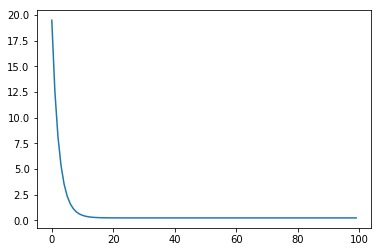

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt


plt.plot(losses)

In [4]:
# 真の係数は[1, 2, 3]
w

Variable containing:
 1.0467
 2.0034
 2.9853
[torch.FloatTensor of size 3]

In [5]:
# pytorchにビルドインされてる線形モデルと最適化法を使ってみる
from torch import nn, optim

# (3, 1)のモデル、切片をout_featureの中にいれるためbias項はなしにする
net = nn.Linear(in_features=3, out_features=1, bias=False)
# 確率的勾配降下法
optimizer = optim.SGD(net.parameters(), lr=0.1)
# 損失関数には最小二乗法をつかう
loss_fn = nn.MSELoss()

In [6]:
losses = []
for epoc in range(100):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])

In [7]:
list(net.parameters())

[Parameter containing:
  1.0467  2.0034  2.9853
 [torch.FloatTensor of size 1x3]]

In [8]:
# アヤメデータを用意する
from sklearn.datasets import load_iris


# 二クラス問題にするため100までしか取り込まない
iris = load_iris()
X = iris.data[:100]
y = iris.target[:100]
X = V(torch.Tensor(X))
y = V(torch.Tensor(y))
print(X.size())
print(y.size())

torch.Size([100, 4])
torch.Size([100])


In [9]:
# アヤメデータの入力(4, 1)のモデル
net = nn.Linear(4, 1)
# 二値問題の分類問題はシグモイド関数を作用させたクロスエントロピーを使う
# シグモイド関数を作用させたクロスエントロピー
loss_fn = nn.BCEWithLogitsLoss()
# 勾配計算は確率的最小勾配法
optimizer = optim.SGD(net.parameters(), lr=0.25)

In [10]:
losses = []
for epoc in range(1000):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, y.view(100, 1))
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])

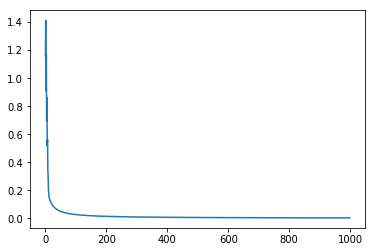

In [11]:
plt.plot(losses)

In [12]:
# 線型結合の結果
h = net(X)
# シグモイドを作用させた確率
prob = nn.functional.sigmoid(h)
# 確率として、0付近の値と1付近の値に固まってるはずなので、0.5以上でマスクする
y_pred = prob > 0.5
# マスクした結果が真の値と同じになる
(y.byte().view(100, 1) == y_pred).sum()

Variable containing:
 100
[torch.ByteTensor of size 1]

In [13]:
from sklearn.datasets import load_digits


# 多クラス問題
digits = load_digits()
X = digits.data
y = digits.target
X = V(torch.Tensor(X))
# CrossEntropyLoss()はLongTensorを返すので計算の型を合わせる
y = V(torch.LongTensor(y))
net = nn.Linear(X.size()[1], 10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

In [14]:
losses = []
for epoc in range(1000):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = loss_fn(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.data[0])

In [15]:
# 答え合わせ
# 確率の最大値のラベルを予測値として集計
# torch.max()は集計軸を指定すると最大値とその位置のタプルを返す
_, y_pred = torch.max(net(X), 1)
# 正解率を計算
(y_pred == y).float().sum() / len(y)

Variable containing:
 0.9889
[torch.FloatTensor of size 1]